In [9]:
import json

from pathlib import Path
from typing import Optional, Dict, List
import matplotlib.pyplot as plt

BENCHMARK_PATH = Path('').resolve().parent / 'benchmark'
RESULTS_PATH = BENCHMARK_PATH / 'results.json'
results = json.load(open(RESULTS_PATH))
benchmarks = results['benchmarks']

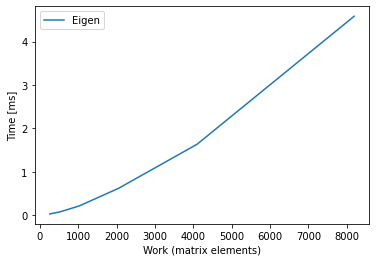

In [10]:
def plot_eigen_wt(ax: Optional[plt.Axes] = None):
    if ax is None:
        _, ax = plt.subplots()
    r = {
        int(run[2]): b['real_time']
        for b in benchmarks if (run := b['name'].split('/'))[1] == 'Eigen'
        }
    ax.plot(
        r.keys(),
        r.values(),
        label='Eigen',
        )
    ax.set_xlabel('Work (matrix elements)')
    ax.set_ylabel('Time [ms]')
    ax.legend()

plot_eigen_wt()

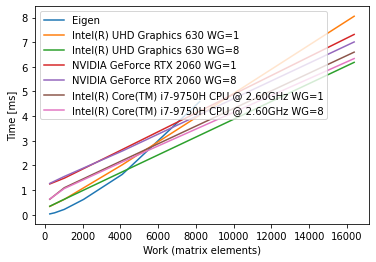

In [11]:
def plot_opencl_wt(
        devices: Dict[int, str],
        workgroup_sizes: List[int],
        ax: Optional[plt.Axes] = None
    ):
    if ax is None:
        _, ax = plt.subplots()
    r = {}
    for b in benchmarks:
        if (
            not (run := b['name'].split('/'))[1] == 'OpenCL'
            and not b.get('errors_ocurred', False)
            ):
            continue
        elif ((device := int(run[3])) not in devices
              or (workgroup_size := int(run[4])) not in workgroup_sizes):
            continue
        r.setdefault(devices[device], {})\
            .setdefault(workgroup_size, {})[int(run[2])] = b['real_time']
    for device, d in r.items():
        for workgroup_size, b in d.items():
            ax.plot(
                b.keys(),
                b.values(),
                label=f'{device} WG={workgroup_size}',
                )
    ax.set_xlabel('Work (matrix elements)')
    ax.set_ylabel('Time [ms]')
    ax.legend()


_, ax = plt.subplots()
plot_eigen_wt(ax)
plot_opencl_wt({
    0: "Intel(R) UHD Graphics 630",
    1: "NVIDIA GeForce RTX 2060",
    2: "Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz"
    }, [1, 8], ax)

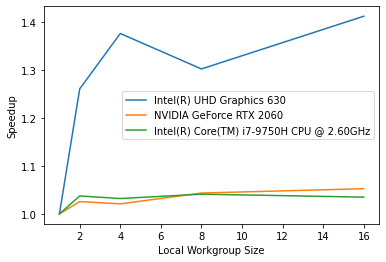

In [12]:
def plot_opencl_us(devices: Dict[int, str], ax: Optional[plt.Axes] = None):
    if ax is None:
        _, ax = plt.subplots()
        r = {}
    for b in benchmarks:
        if (
            not (run := b['name'].split('/'))[1] == 'OpenCL'
            and not b.get('errors_ocurred', False)
            ):
            continue
        elif (device := int(run[3])) not in devices:
            continue
        workgroup_size = int(run[4])
        work = int(run[2])
        r.setdefault(devices[device],
                     {})[workgroup_size] = work / b['real_time']
    for device, d in r.items():
        speedup = {wgs: s / d[1] for wgs, s in d.items()}
        ax.plot(
            speedup.keys(),
            speedup.values(),
            label=f'{device}',
            )
    ax.set_xlabel('Local Workgroup Size')
    ax.set_ylabel('Speedup')
    ax.legend()


plot_opencl_us({
    0: "Intel(R) UHD Graphics 630",
    1: "NVIDIA GeForce RTX 2060",
    2: "Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz"
    })